# This notebook trains and saves BuDDI4 models across hyperparaemter combinations

In [1]:
import gc
import sys
import yaml
import uuid
import joblib
import pathlib
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError

2025-05-13 00:34:46.766336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 00:34:46.775452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747118086.785024 1465440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747118086.787869 1465440 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747118086.796053 1465440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

## Obtain repository root directory for access to preprocessed data, config file and local package

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Import packages

In [ ]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils import plot_buddi4_loss, write_buddi4_loss_config

from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import kl_loss
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4

I0000 00:00:1747118087.746442 1465440 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3457 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Define paths to Input Files/Output

### Input from pre-processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
train_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_data.pkl'
assert train_data_file.exists(), f"Train data file not found at {train_data_file}"

### Model weight output saved to...

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
TRAINED_MODELS_PATH.mkdir(exist_ok=True)

## Training

### Load train data

In [7]:
buddi4_data = joblib.load(train_data_file)

(
    X_kp,
    y_kp,
    label_kp,
    stim_kp,
    samp_type_kp,
    meta_kp
) = buddi4_data.query(
    isTraining='Train',
    samp_type='sc_ref'
).get()

(
    X_unkp,
    y_unkp,
    label_unkp,
    stim_unkp,
    samp_type_unkp,
    meta_unkp
) = buddi4_data.query(
    isTraining='Train',
    samp_type='bulk'
).get()

n_x = buddi4_data.nx
n_y = buddi4_data.ny
n_labels = buddi4_data.n_labels
n_stims = buddi4_data.n_stims
n_samp_types = buddi4_data.n_samp_types
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


### Convert data to tensorflow dataset

In [8]:
ds_sup = get_supervised_dataset(
    X_known_prop=X_kp,
    Y_known_prop=y_kp,
    label_known_prop=label_kp,
    stim_known_prop=stim_kp,
    samp_type_known_prop=samp_type_kp,
)
print(f"Number of entries in supervised dataset: {ds_sup.cardinality().numpy()}")
ds_sup_batch_x, ds_sup_batch_y = next(iter(ds_sup))

ds_unsup = get_unsupervised_dataset(
    X_unknown_prop=X_unkp,
    label_unknown_prop=label_unkp,
    stim_unknown_prop=stim_unkp,
    samp_type_unknown_prop=samp_type_unkp,
)
print(f"Number of entries in unsupervised dataset: {ds_unsup.cardinality().numpy()}")

print("\nTake a peek at the dataset generator return:\n")

ds_sup_batch_input, ds_sup_batch_target = next(iter(ds_sup.batch(16).take(1)))
ds_sup_batch_x, ds_sup_batch_y = ds_sup_batch_input
print(f"Supervised batch x shape: {ds_sup_batch_x.shape}")
print(f"Supervised batch y shape: {ds_sup_batch_y.shape}")
ds_sup_batch_target_x, _, _, _, _, ds_sup_batch_label, ds_sup_batch_stim, ds_sup_batch_samp_type, ds_sup_batch_target_y = ds_sup_batch_target
print(f"Supervised batch target x shape: {ds_sup_batch_target_x.shape}")
print(f"Supervised batch target y shape: {ds_sup_batch_target_y.shape}")
print(f"Supervised batch label shape: {ds_sup_batch_label.shape}")
print(f"Supervised batch stim shape: {ds_sup_batch_stim.shape}")
print(f"Supervised batch samp_type shape: {ds_sup_batch_samp_type.shape}")

print("\n")

ds_unsup_batch_input, ds_unsup_batch_target = next(iter(ds_unsup.batch(16).take(1)))
ds_unsup_batch_x, = ds_unsup_batch_input
print(f"Unsupervised batch x shape: {ds_unsup_batch_x.shape}")
ds_unsup_batch_target_x, _, _, _, _, ds_unsup_batch_label, ds_unsup_batch_stim, ds_unsup_batch_samp_type, _ = ds_unsup_batch_target
print(f"Unsupervised batch target x shape: {ds_unsup_batch_target_x.shape}")
print(f"Unsupervised batch label shape: {ds_unsup_batch_label.shape}")
print(f"Unsupervised batch stim shape: {ds_unsup_batch_stim.shape}")
print(f"Unsupervised batch samp_type shape: {ds_unsup_batch_samp_type.shape}")

Number of entries in supervised dataset: 8400
Number of entries in unsupervised dataset: 588

Take a peek at the dataset generator return:

Supervised batch x shape: (16, 7000)
Supervised batch y shape: (16, 11)
Supervised batch target x shape: (16, 7000)
Supervised batch target y shape: (16, 11)
Supervised batch label shape: (16, 593)
Supervised batch stim shape: (16, 2)
Supervised batch samp_type shape: (16, 2)


Unsupervised batch x shape: (16, 7000)
Unsupervised batch target x shape: (16, 7000)
Unsupervised batch label shape: (16, 593)
Unsupervised batch stim shape: (16, 2)
Unsupervised batch samp_type shape: (16, 2)


#### Format data for visualization

In [9]:
# Down-sample the sc_ref and bulk data for visualization
(
    X_kp_tmp,
    Y_kp_tmp,
    meta_kp_tmp
) = buddi4_data.query(
    isTraining='Train',
    samp_type='sc_ref'
).get(
    ('X', 'Y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

(
    X_unkp_tmp,
    Y_unkp_tmp,
    meta_unkp_tmp
) = buddi4_data.query(
    isTraining='Train',
    samp_type='bulk'
).get(
    ('X', 'Y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

cell_types = buddi4_data.cell_type_names
X_tmp = np.concatenate((X_kp_tmp, X_unkp_tmp), axis=0)
Y_tmp = np.concatenate((Y_kp_tmp, Y_unkp_tmp), axis=0)
meta_tmp = pd.concat((meta_kp_tmp, meta_unkp_tmp), axis=0)


idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

### Model training parameters

In [10]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.0005

### Create a grid of hyper-parameter combinations

In [11]:
RECONST_ALPHAS = [1.0, 10.0]
CLS_ALPHAS = [100.0]
Y_ALPHAS = [100.0]

BETAS = [1.0, 10.0, 100.0]
LABEL_BETAS = [1.0, 10.0, 100.0]
SLACK_BETAS = [0.1]

hyperparam_list_names = [
    'RECONST_ALPHAS',
    'CLS_ALPHAS',
    'Y_ALPHAS',
    'BETAS',
    'LABEL_BETAS',
    'SLACK_BETAS',
]

hyperparam_lists = [
    RECONST_ALPHAS,
    CLS_ALPHAS,
    Y_ALPHAS,
    BETAS,
    LABEL_BETAS,
    SLACK_BETAS,
]

arrays = [np.array(lst) for lst in hyperparam_lists]
grids = np.meshgrid(*arrays, indexing='ij')
stacked = np.stack(grids, axis=-1)
all_combos = stacked.reshape(-1, len(hyperparam_lists))
hyperparam_grid = pd.DataFrame(all_combos, columns=hyperparam_list_names)
hyperparam_grid.head()

RECONST_ALPHAS  CLS_ALPHAS  Y_ALPHAS  BETAS  LABEL_BETAS  SLACK_BETAS
0             1.0       100.0     100.0    1.0          1.0          0.1
1             1.0       100.0     100.0    1.0         10.0          0.1
2             1.0       100.0     100.0    1.0        100.0          0.1
3             1.0       100.0     100.0   10.0          1.0          0.1
4             1.0       100.0     100.0   10.0         10.0          0.1

In [12]:
trained_configs = []
rm_empty_dirs = True

for subdir in TRAINED_MODELS_PATH.iterdir():
    if subdir.is_dir():
        config_file = subdir / "loss_config.yaml"
        loss_csv_file = subdir / "train_loss.csv"
        if config_file.exists() and loss_csv_file.exists():
            with open(config_file, 'r') as f:
                try:
                    config_dict = yaml.safe_load(f)
                    trained_configs.append(config_dict)
                except yaml.YAMLError as e:
                    print(f"Failed to parse YAML in {config_file}: {e}")
        elif rm_empty_dirs:
            # delete the directory as it is most likely from a failed run
            print(f"Deleting directory {subdir} as it does not contain the expected files.")
            for file in subdir.iterdir():
                file.unlink()
            subdir.rmdir()

print(f"Number of trained configs: {len(trained_configs)}")

Deleting directory /home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/train_plots as it does not contain the expected files.
Deleting directory /home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_e4e31a1b;beta=100.0;label_beta=10.0;slack_beta=0.1 as it does not contain the expected files.
Deleting directory /home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_b185d7d2;beta=100.0;label_beta=1.0;slack_beta=0.1 as it does not contain the expected files.
Deleting directory /home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_b5612cf5;beta=100.0;label_beta=10.0;slack_beta=0.1 as it does not contain the expected files.
Deleting directory /home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=10.0_beta_label=1.0_beta_slack=0.1 as it does not contain the expected files.
Number of trained configs: 9


Model with config 0: 
RECONST_ALPHAS      1.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS               1.0
LABEL_BETAS         1.0
SLACK_BETAS         0.1
Name: 0, dtype: float64
 already trained, skipping...

Model with config 1: 
RECONST_ALPHAS      1.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS               1.0
LABEL_BETAS        10.0
SLACK_BETAS         0.1
Name: 1, dtype: float64
 already trained, skipping...

Model with config 2: 
RECONST_ALPHAS      1.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS               1.0
LABEL_BETAS       100.0
SLACK_BETAS         0.1
Name: 2, dtype: float64
 already trained, skipping...

Model with config 3: 
RECONST_ALPHAS      1.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS              10.0
LABEL_BETAS         1.0
SLACK_BETAS         0.1
Name: 3, dtype: float64
 already trained, skipping...

Model with config 4: 
RECONST_ALPHAS      1.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS              10.

Epoch 1/10:   0%|          | 0/525 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1747118099.892176 1465440 service.cc:152] XLA service 0x5f0e18bce170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747118099.892189 1465440 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-13 00:34:59.949108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747118100.312028 1465440 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747118102.185327 1465440 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 10/10: 100%|██████████| 525/525 [03:08<00:00,  2.79it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages

Training complete!


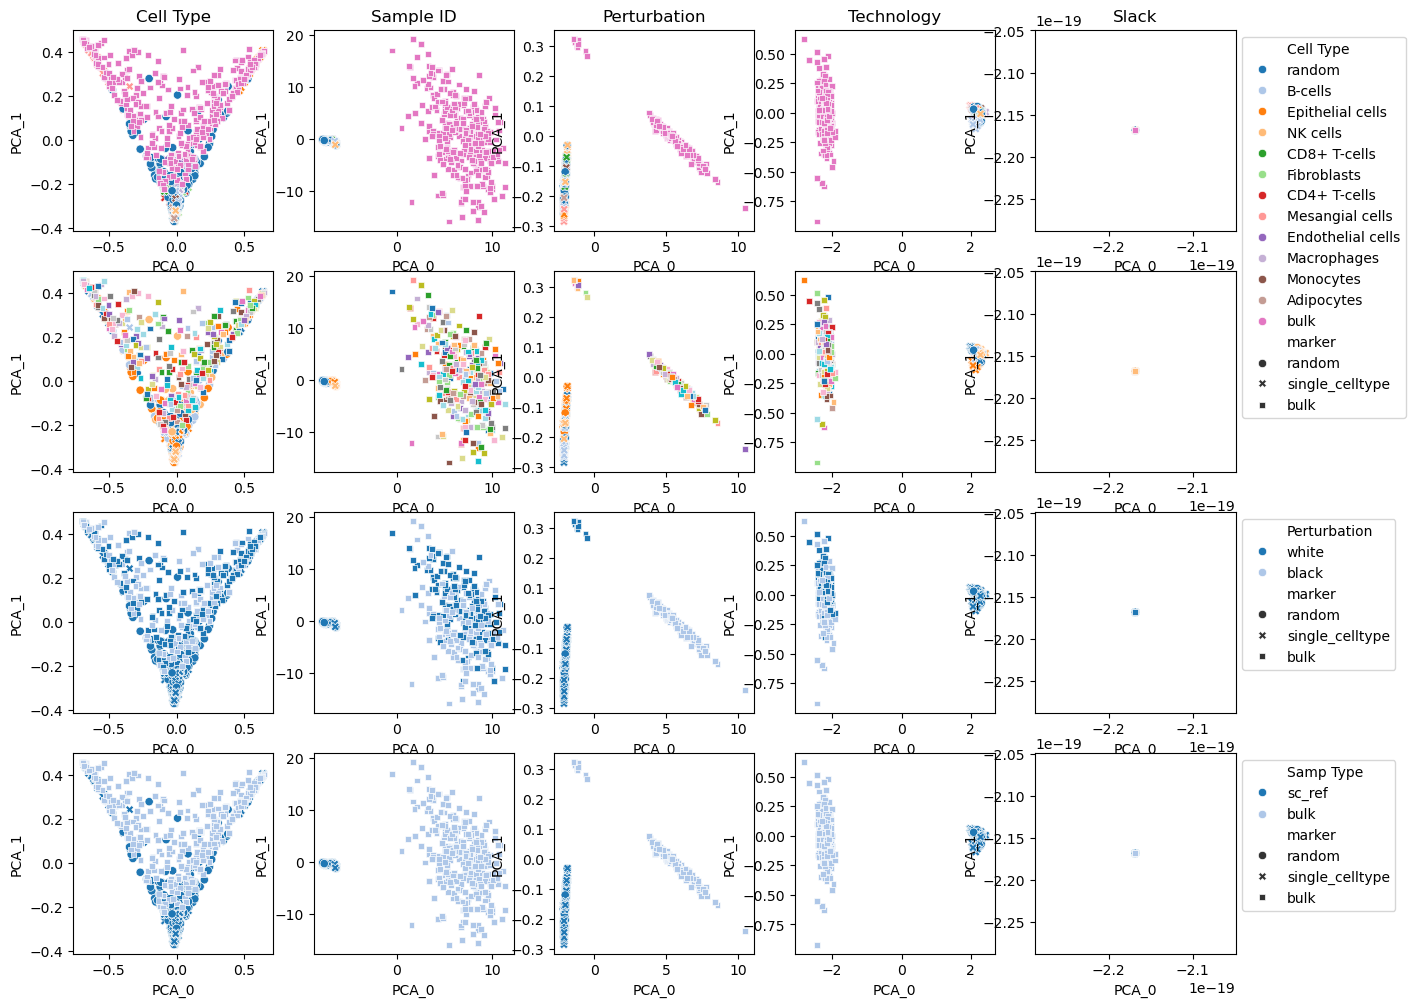

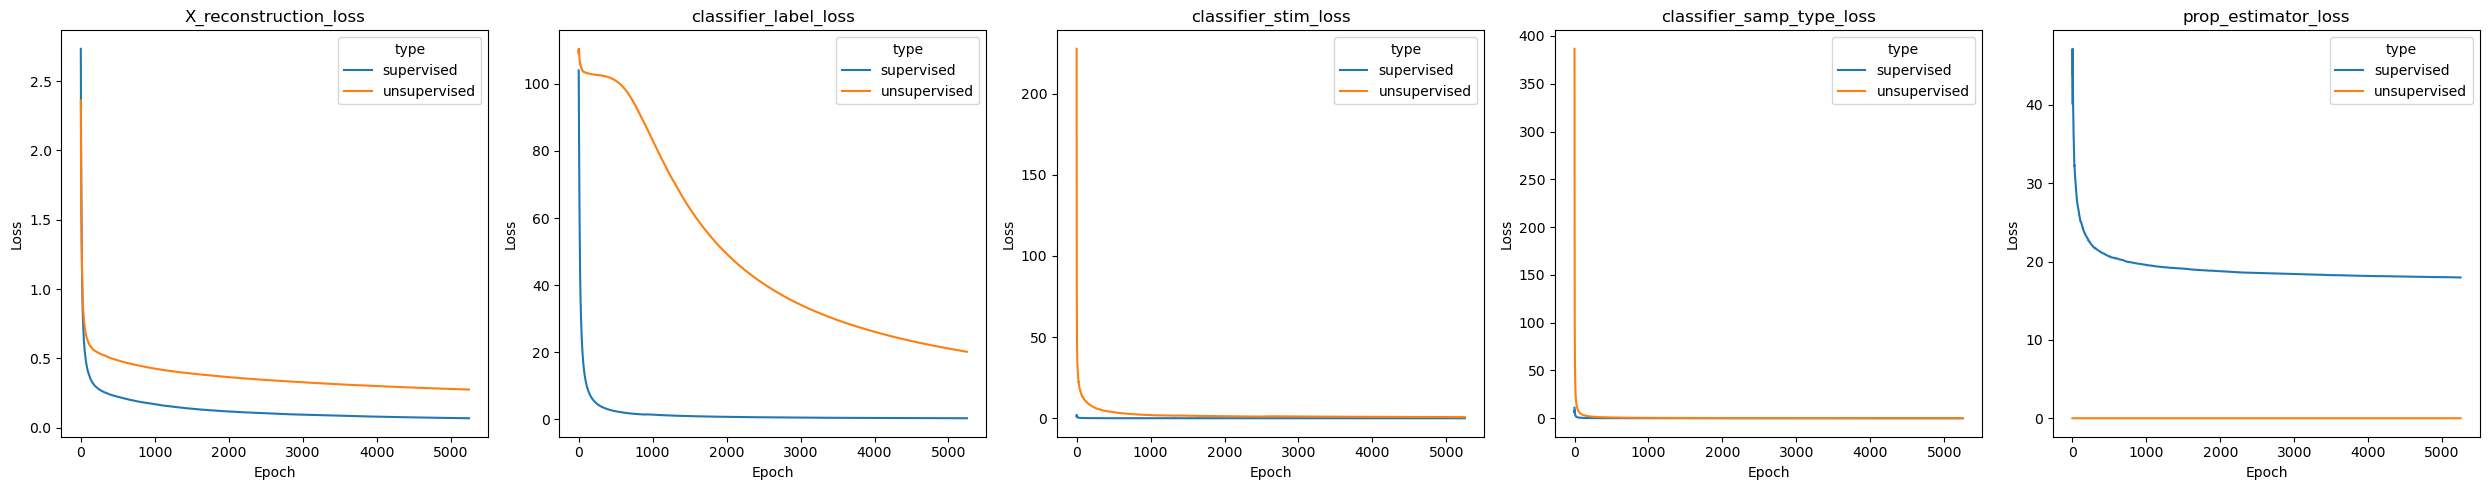

Training Model with config 10: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS               1.0
LABEL_BETAS        10.0
SLACK_BETAS         0.1
Name: 10, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:08<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


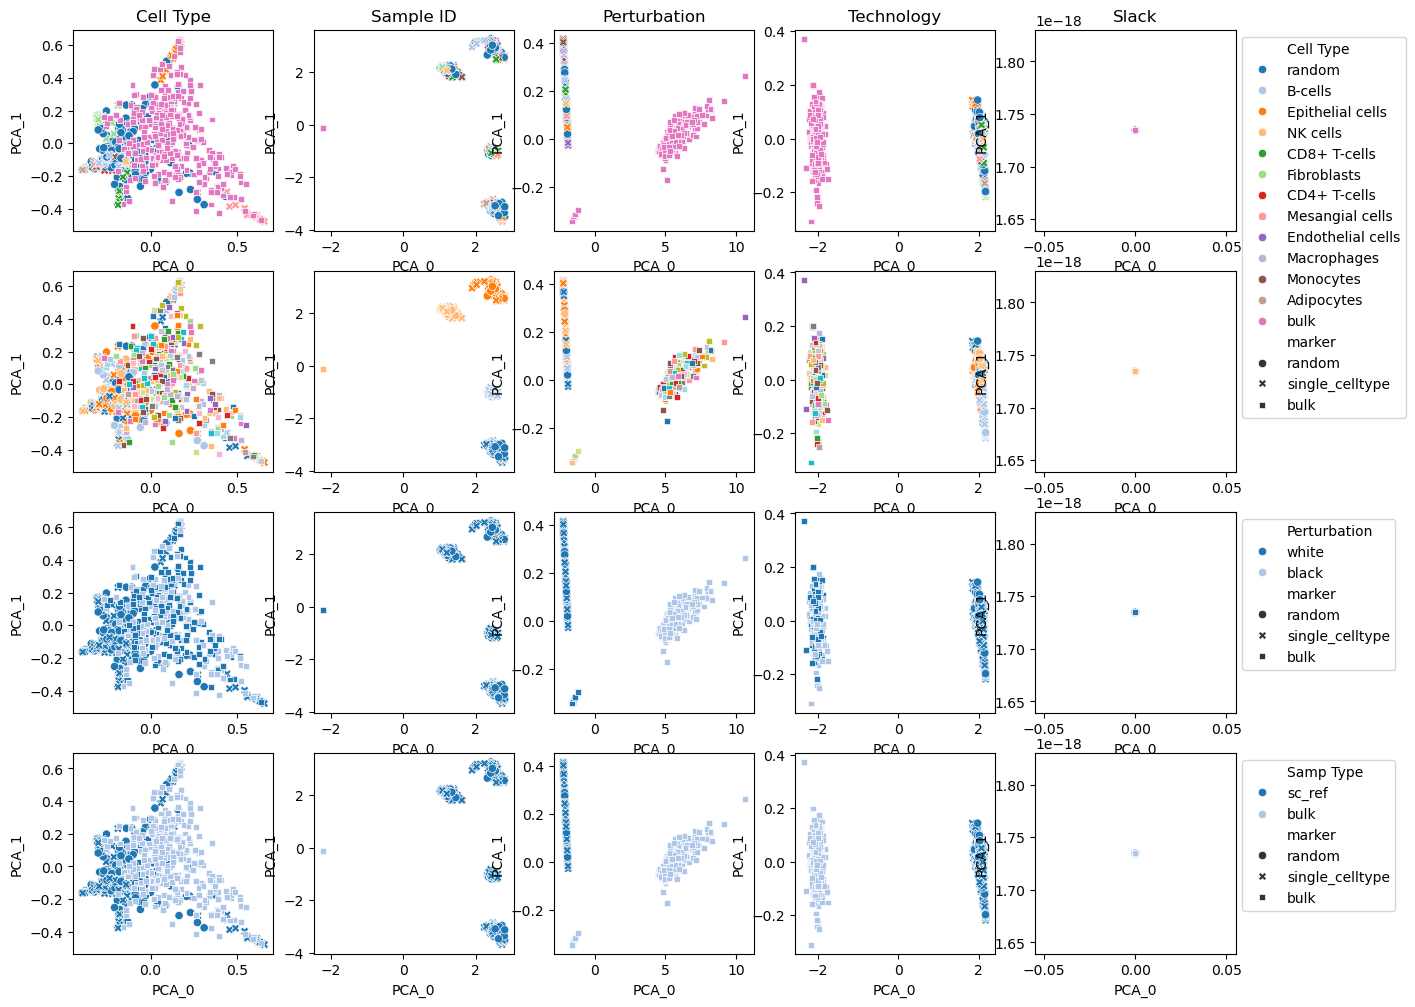

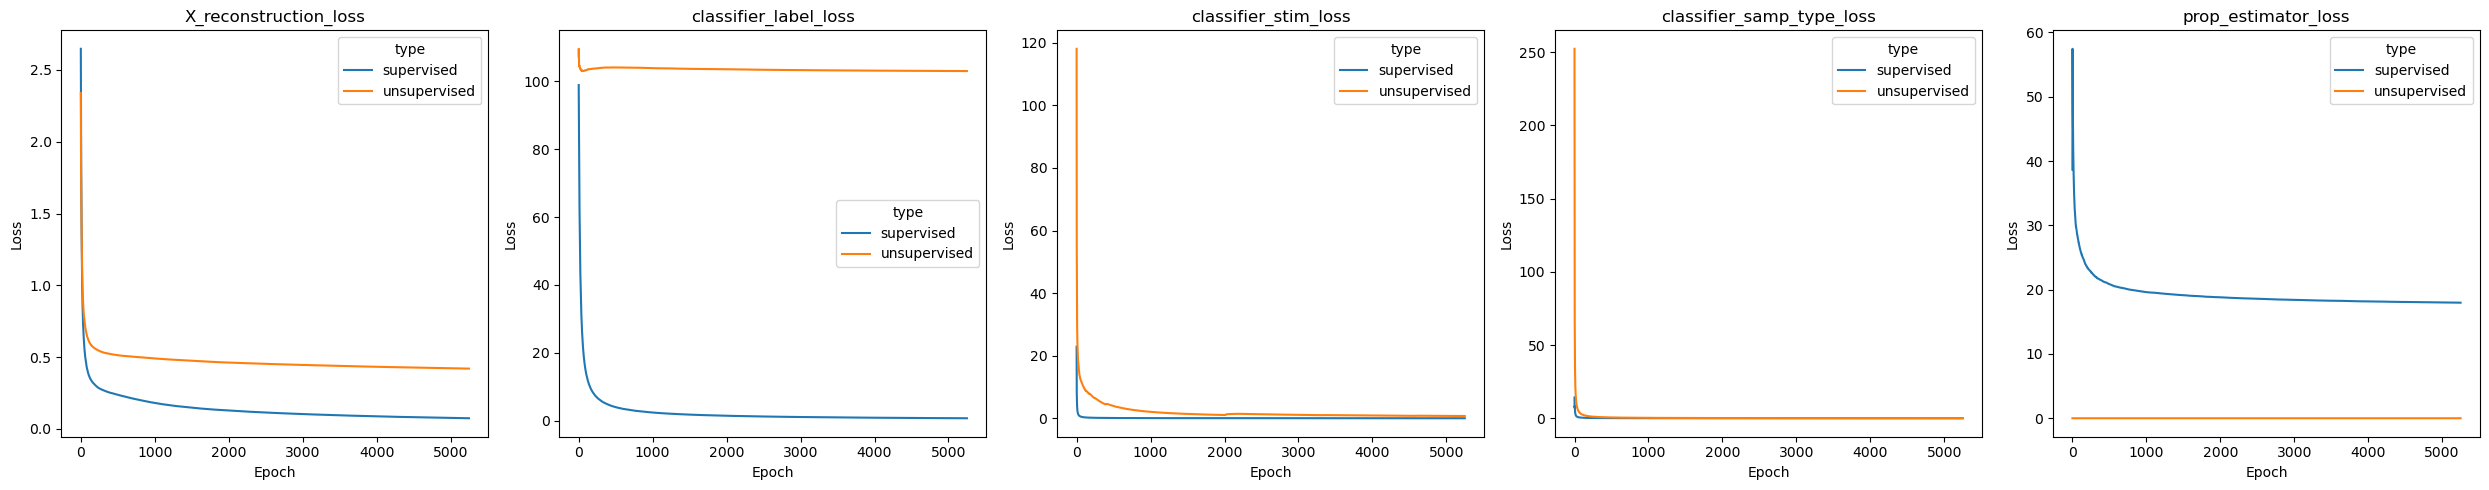

Training Model with config 11: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS               1.0
LABEL_BETAS       100.0
SLACK_BETAS         0.1
Name: 11, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:08<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


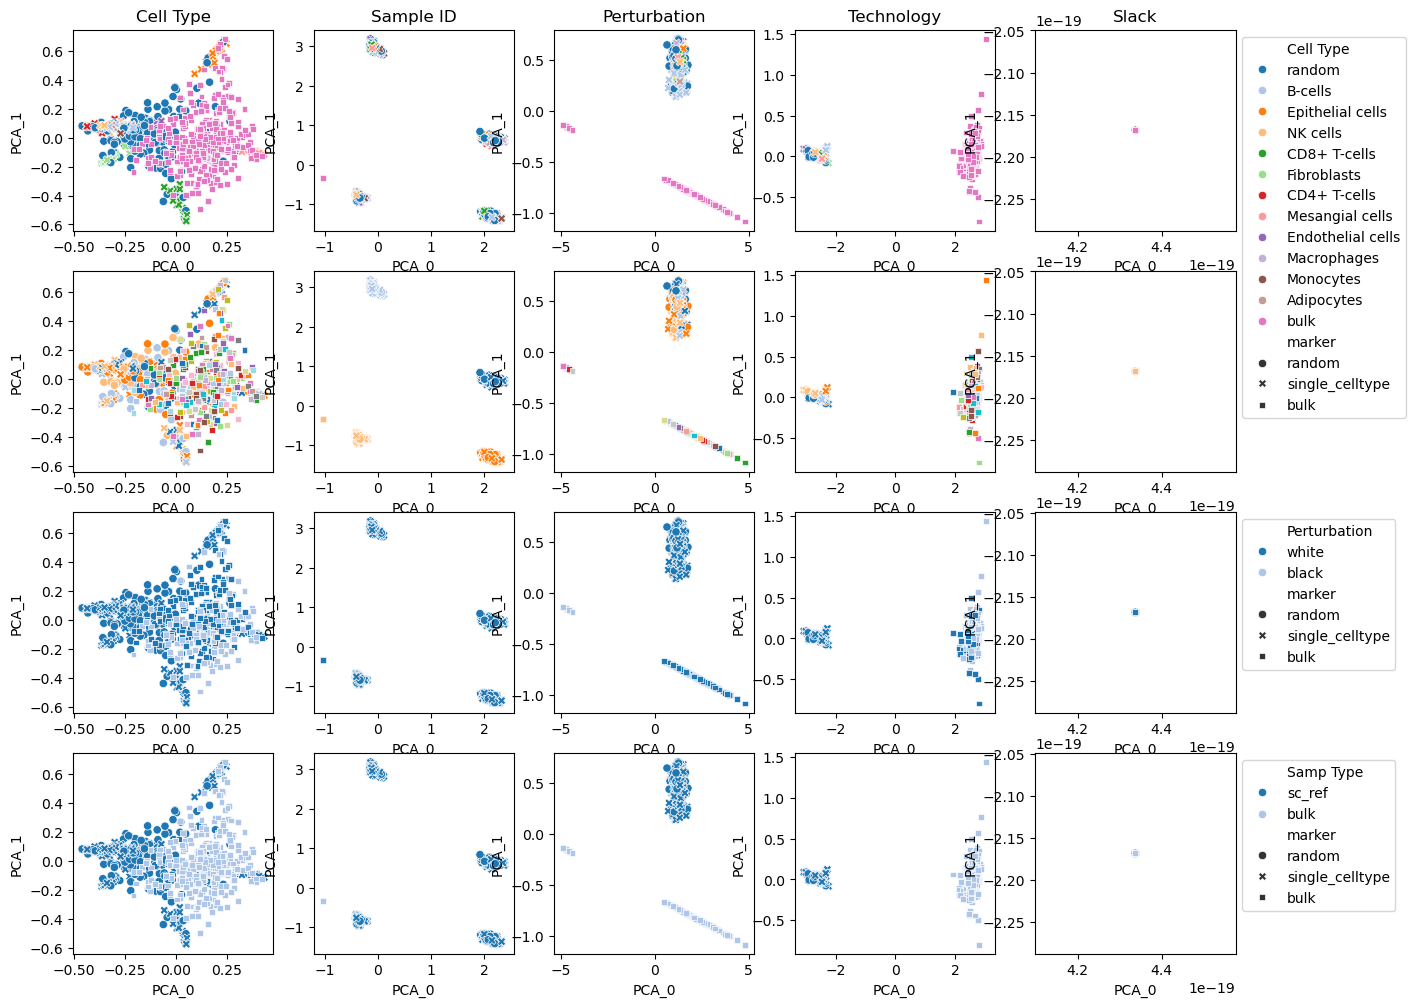

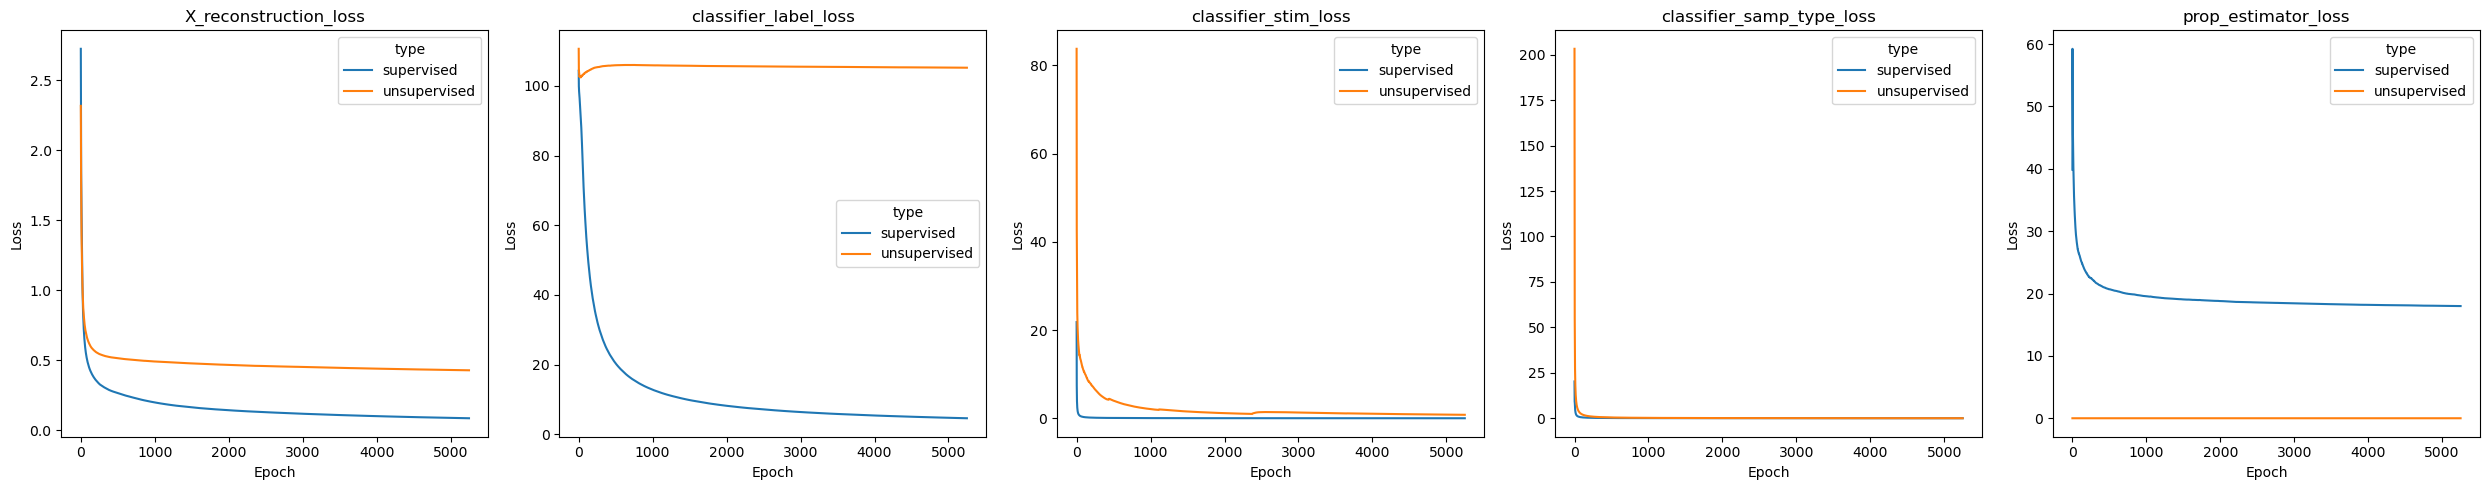

Training Model with config 12: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS              10.0
LABEL_BETAS         1.0
SLACK_BETAS         0.1
Name: 12, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:09<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


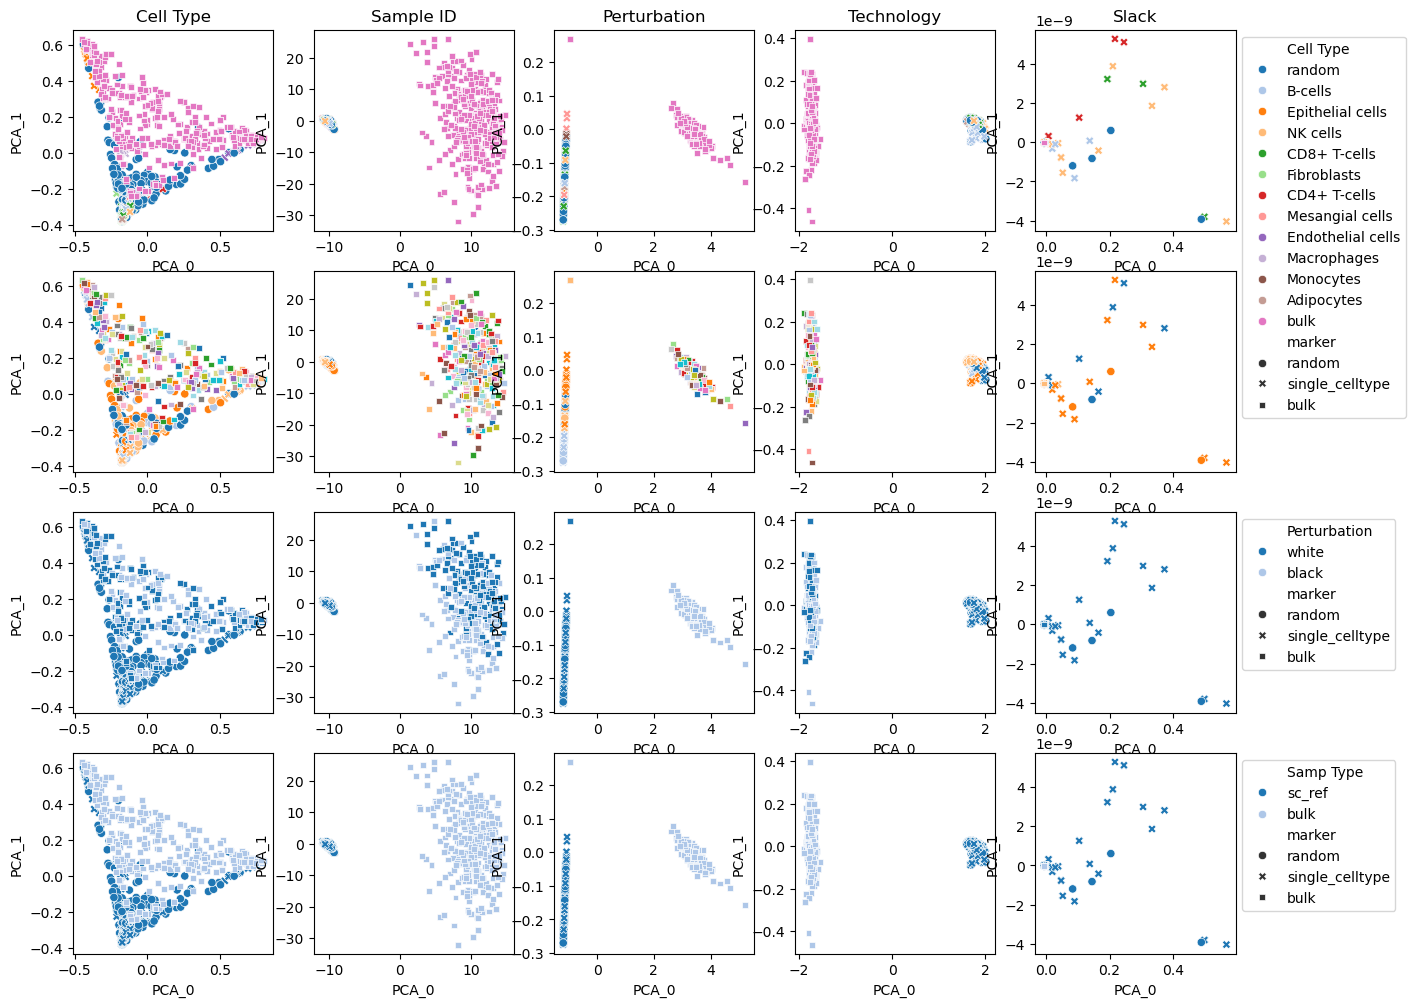

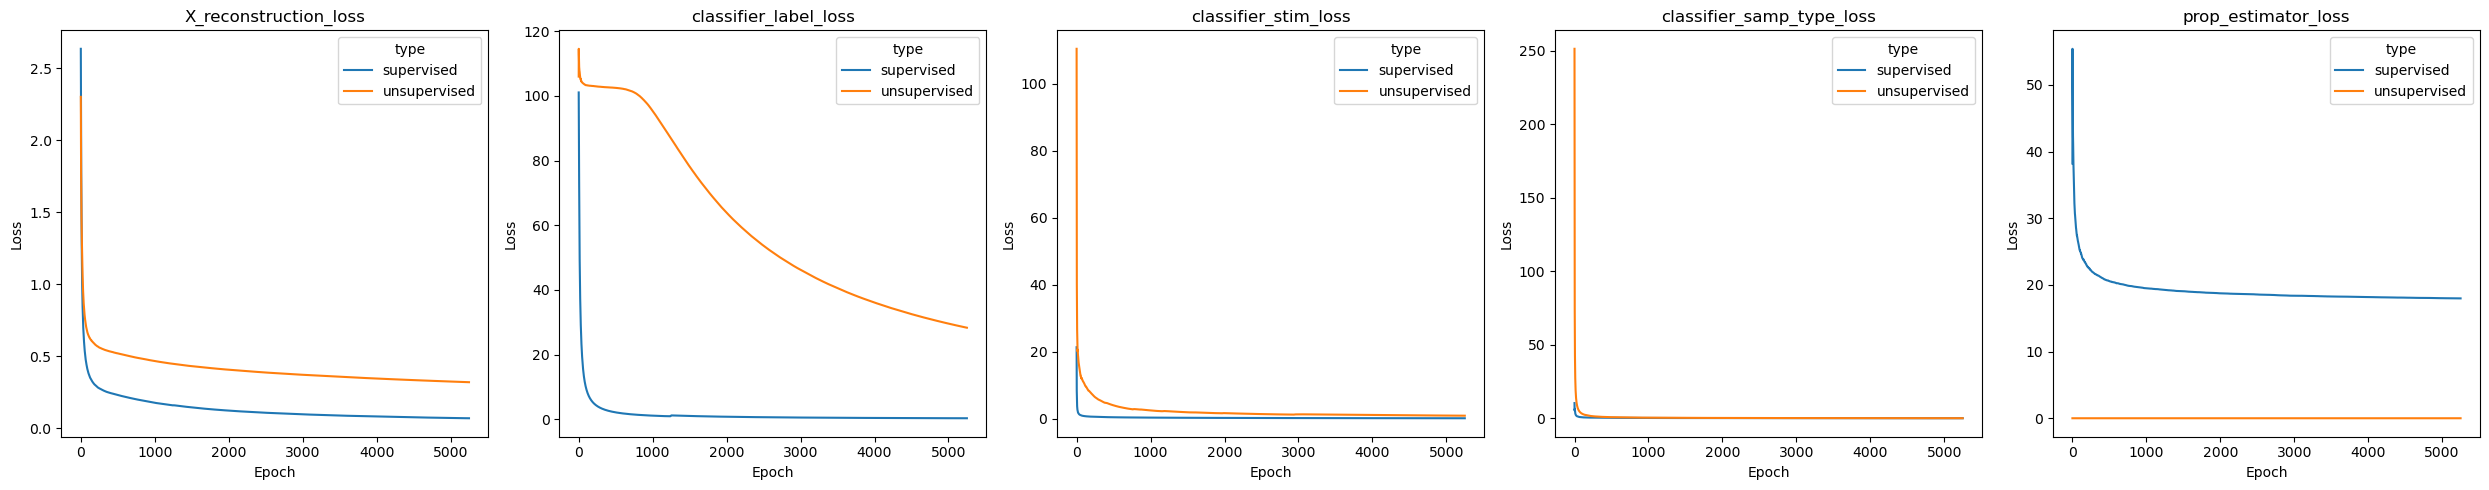

Training Model with config 13: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS              10.0
LABEL_BETAS        10.0
SLACK_BETAS         0.1
Name: 13, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:09<00:00,  2.77it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


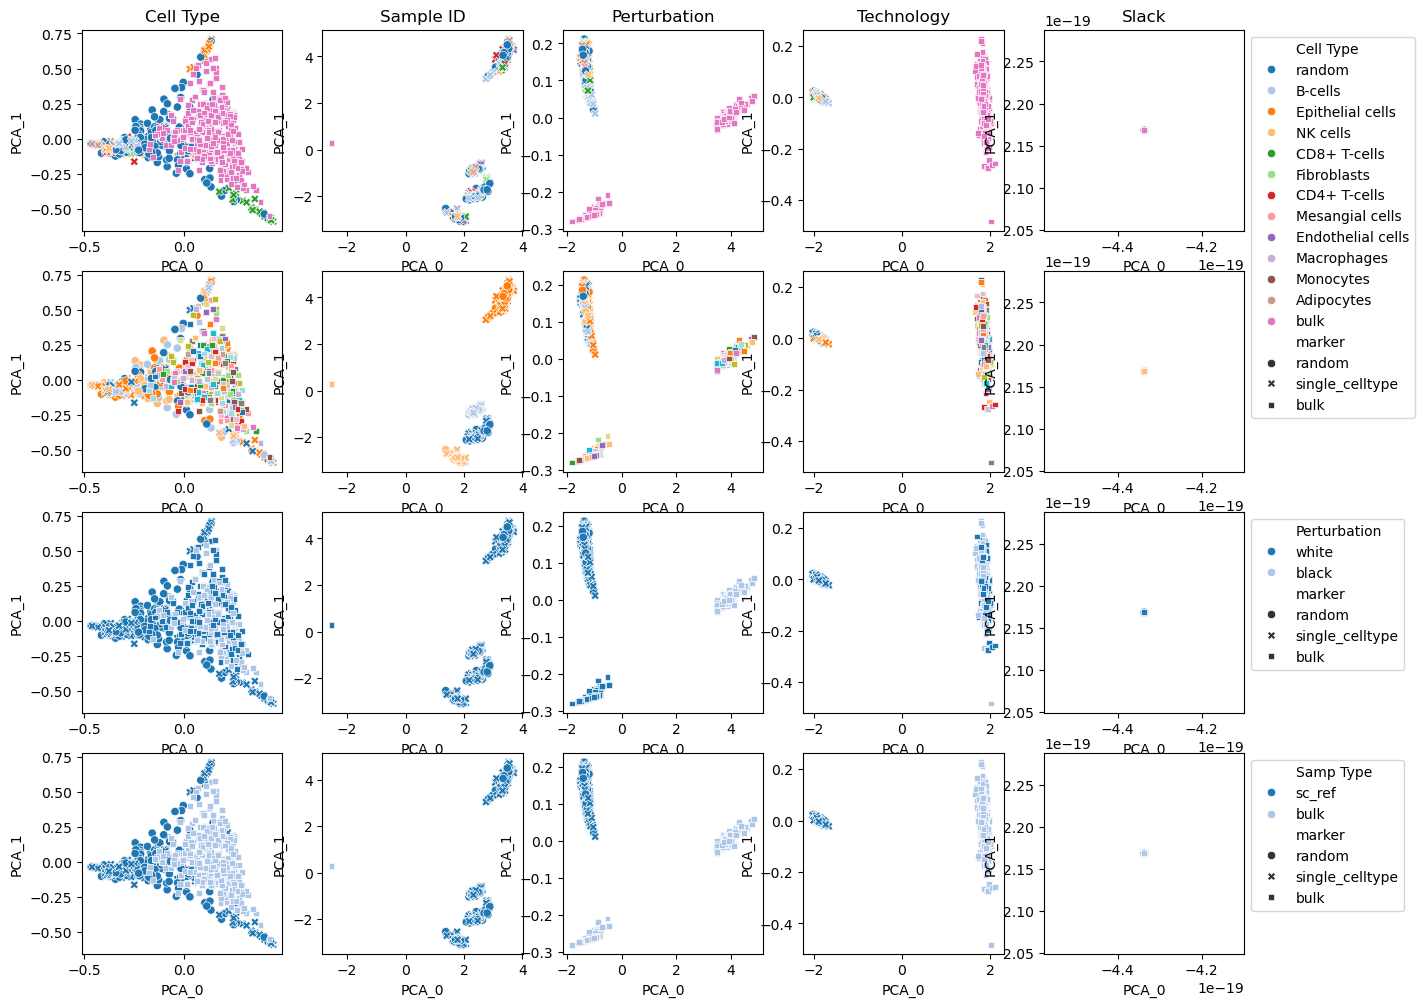

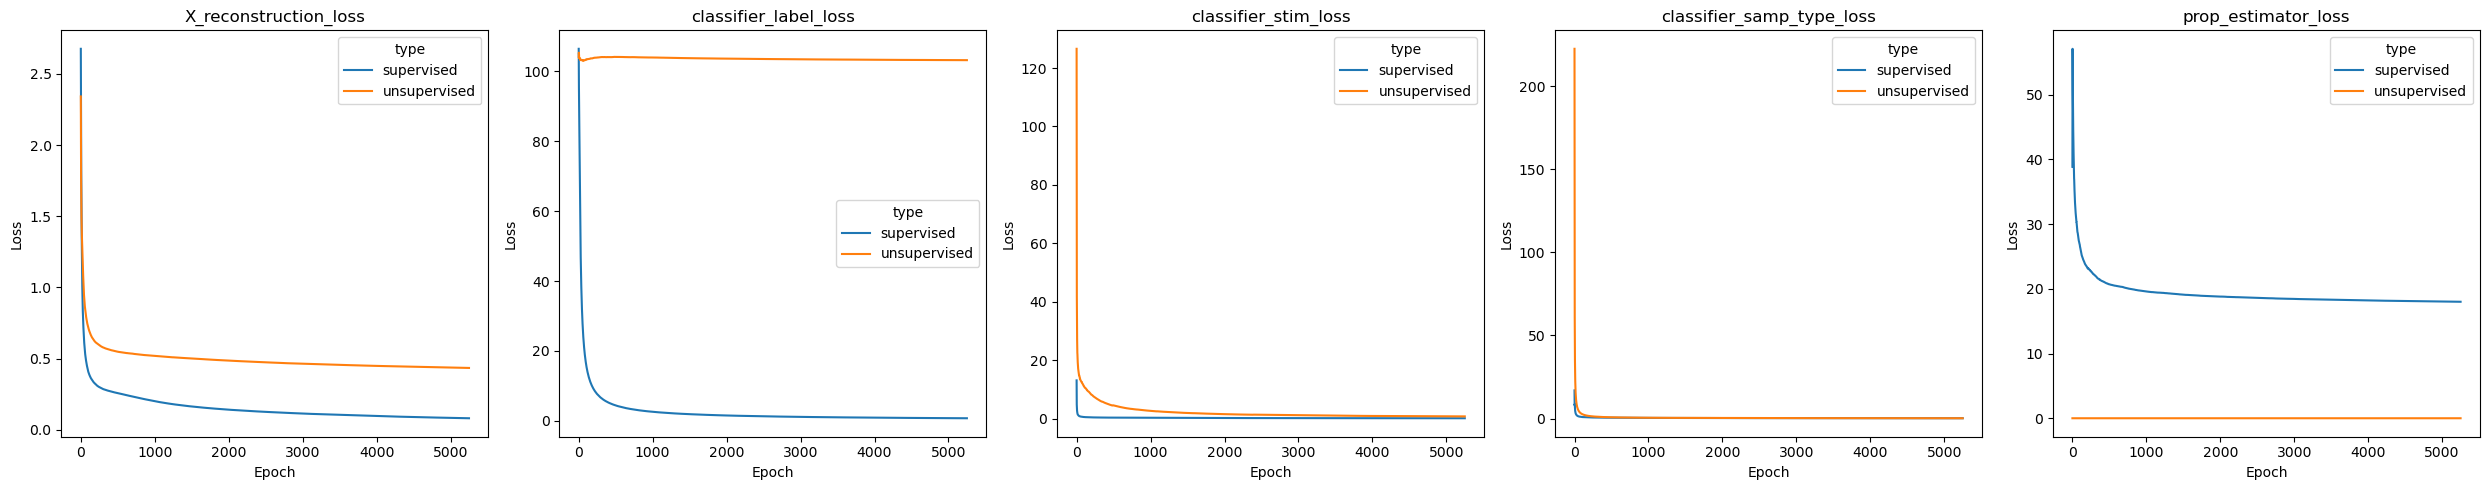

Training Model with config 14: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS              10.0
LABEL_BETAS       100.0
SLACK_BETAS         0.1
Name: 14, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:08<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


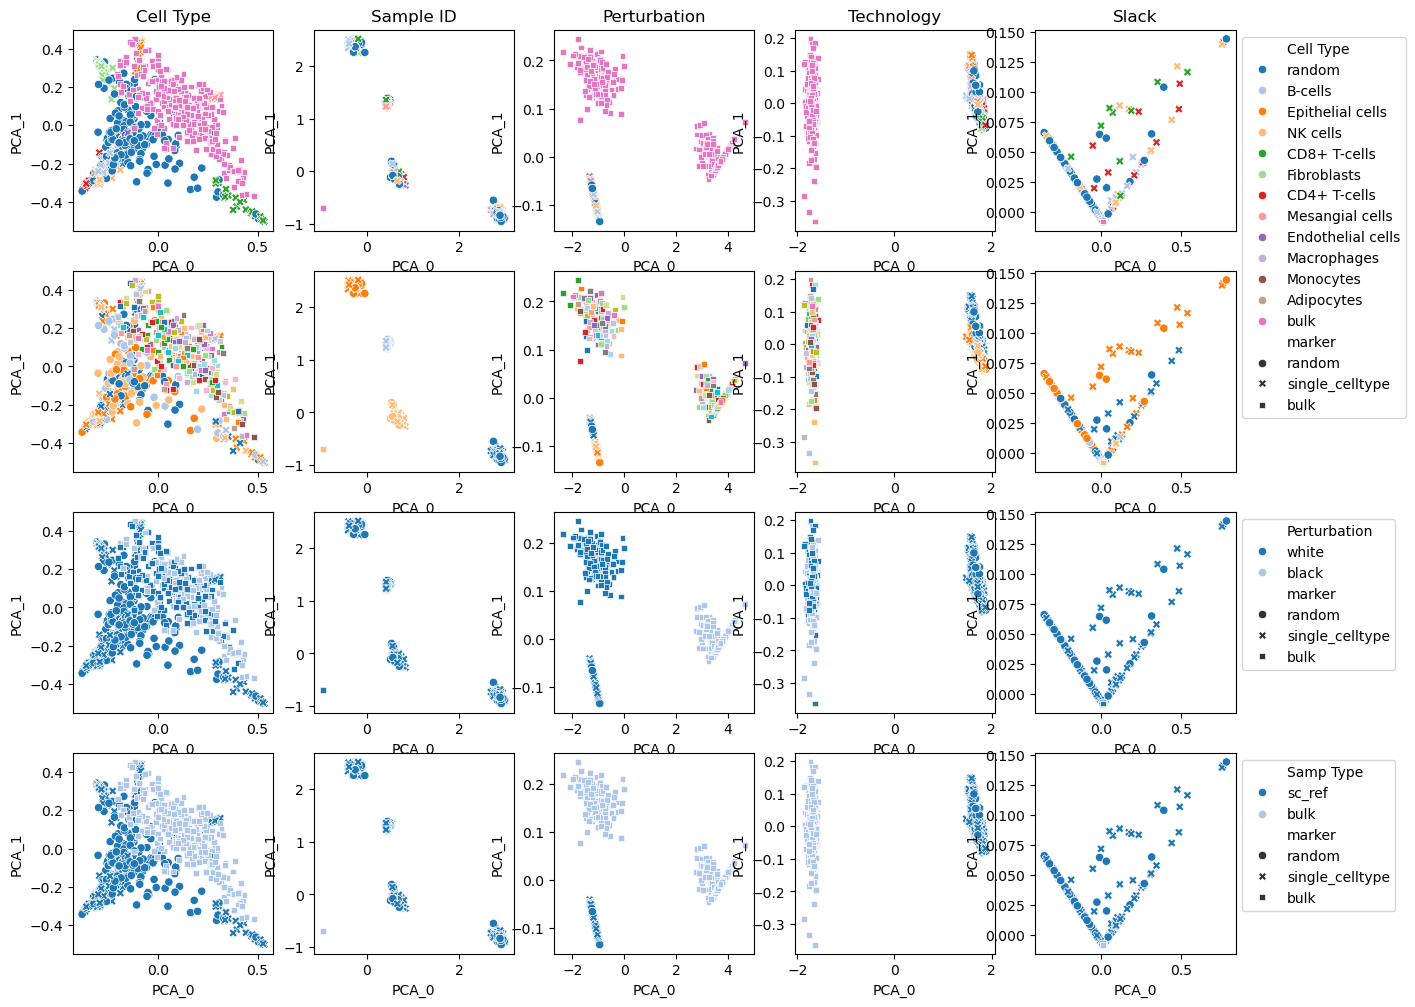

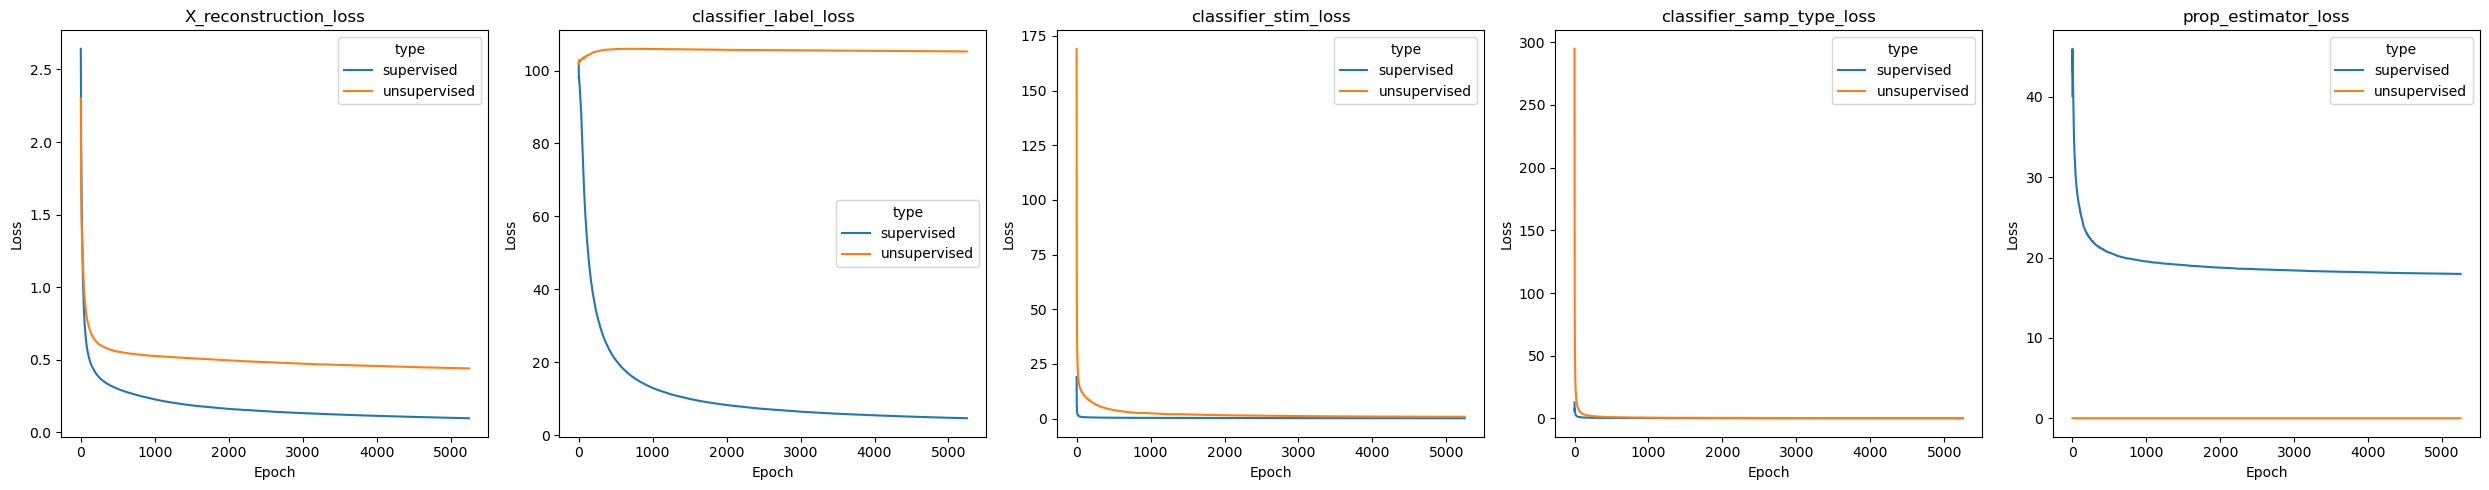

Training Model with config 15: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS             100.0
LABEL_BETAS         1.0
SLACK_BETAS         0.1
Name: 15, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:09<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


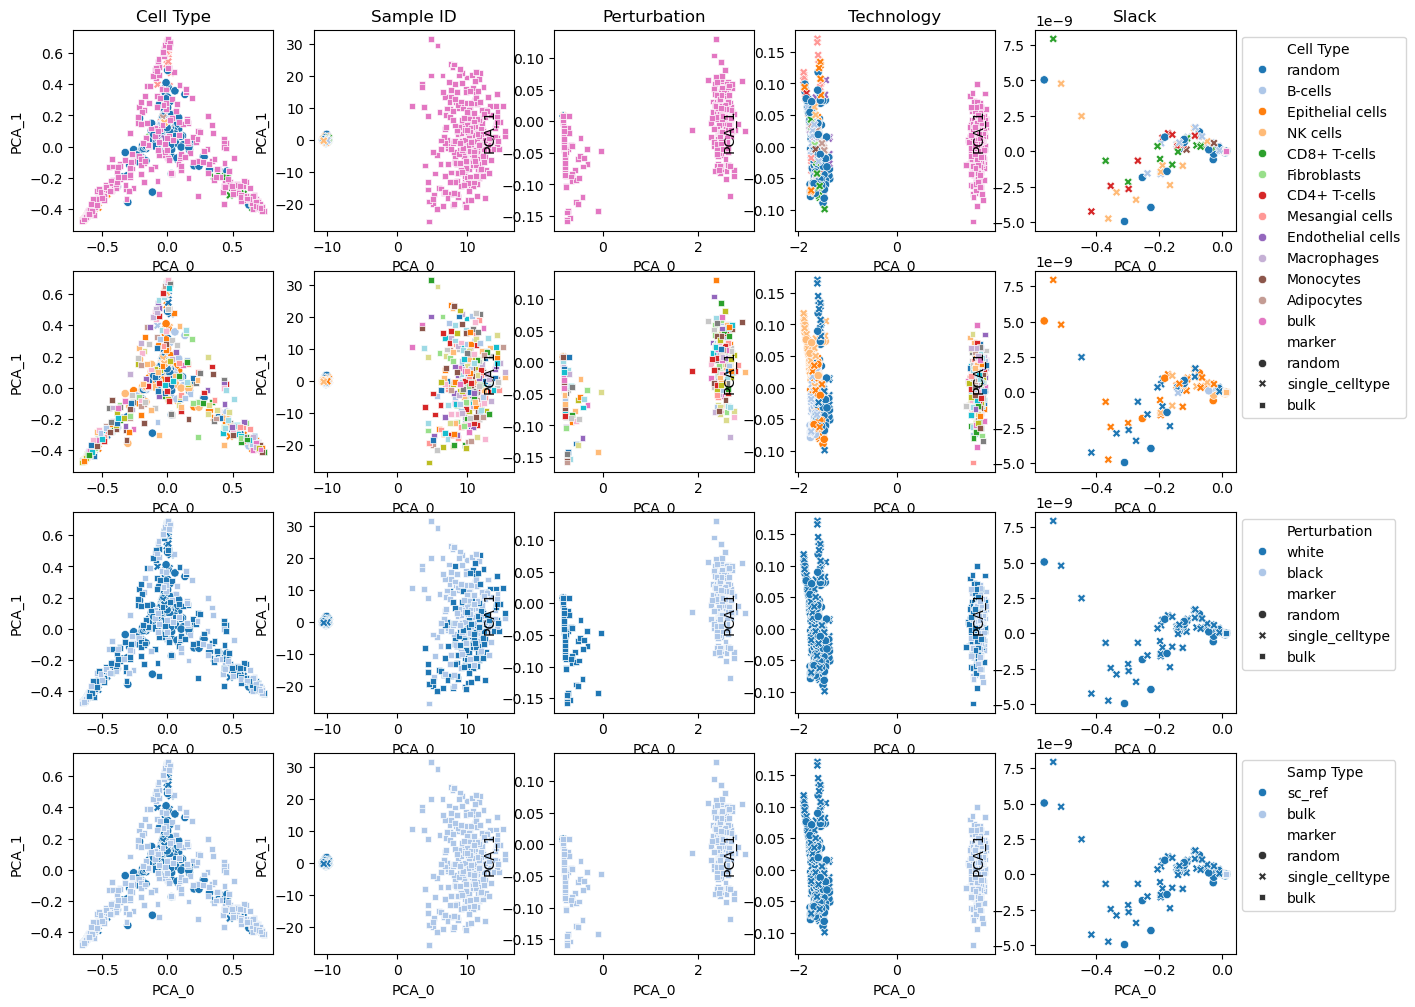

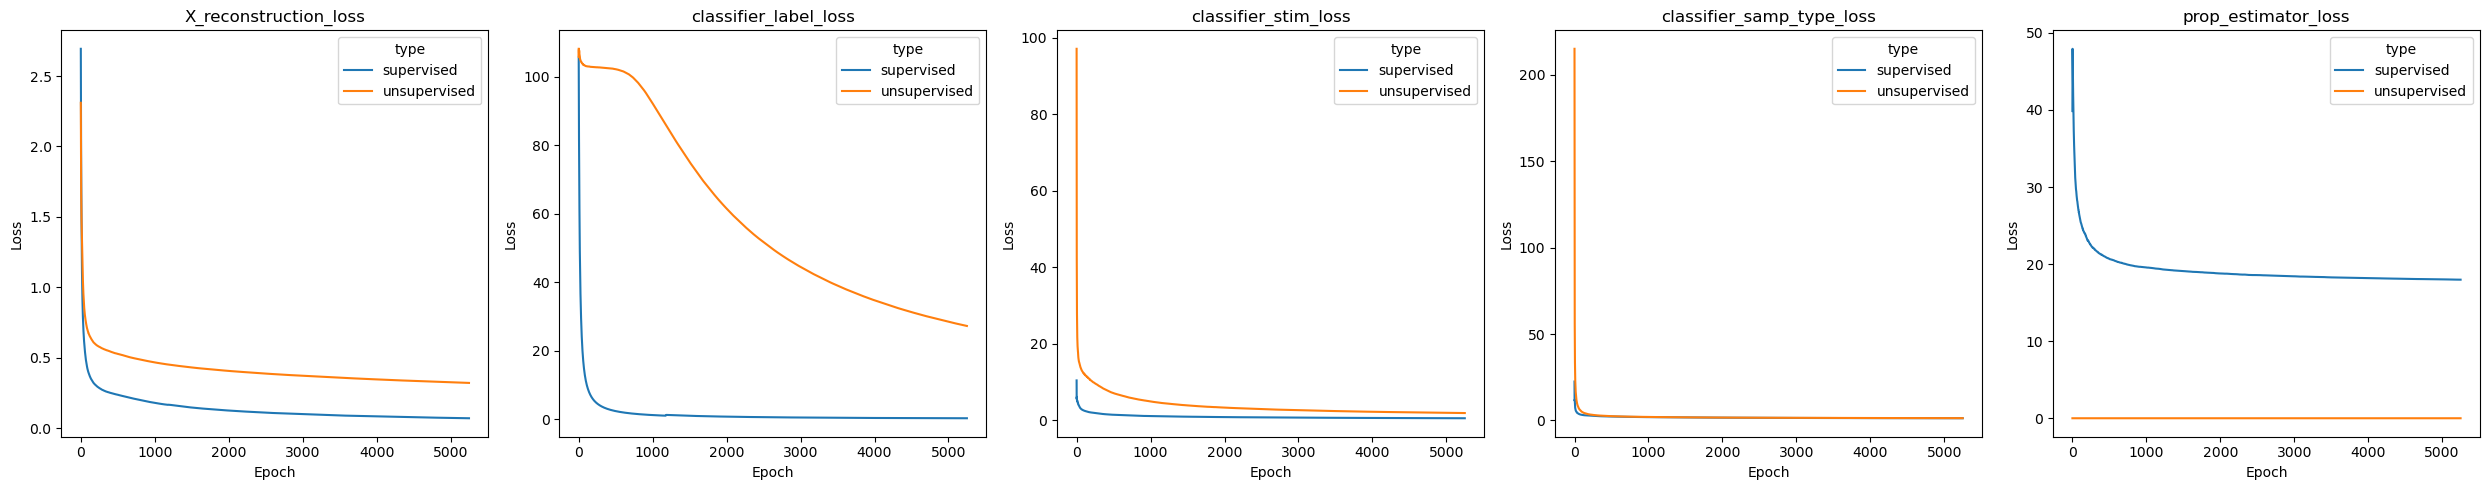

Training Model with config 16: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS             100.0
LABEL_BETAS        10.0
SLACK_BETAS         0.1
Name: 16, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:08<00:00,  2.78it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


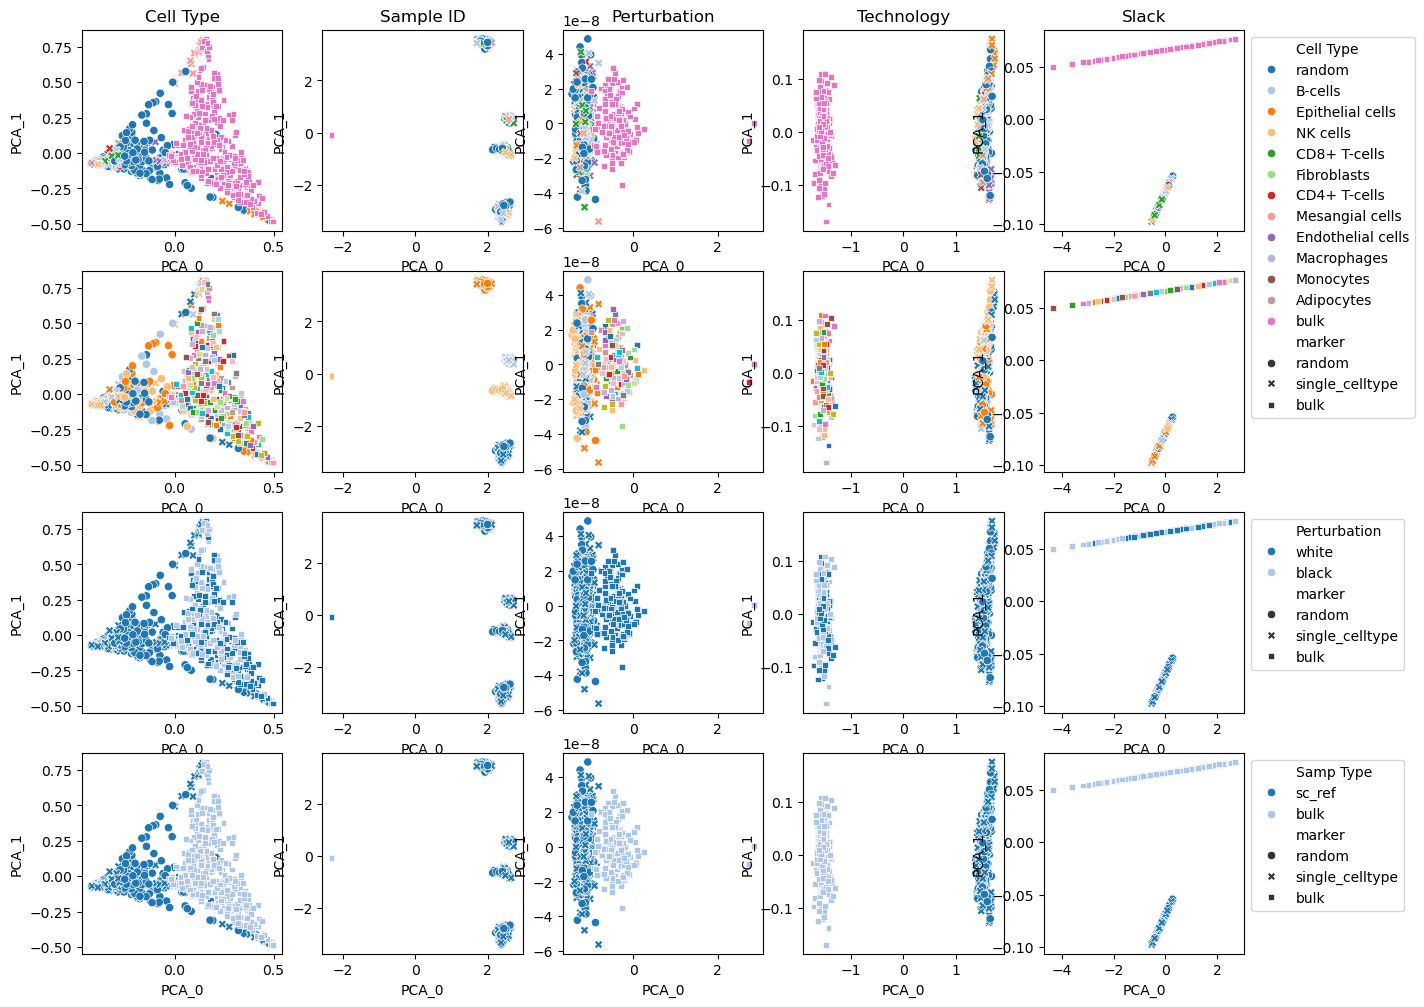

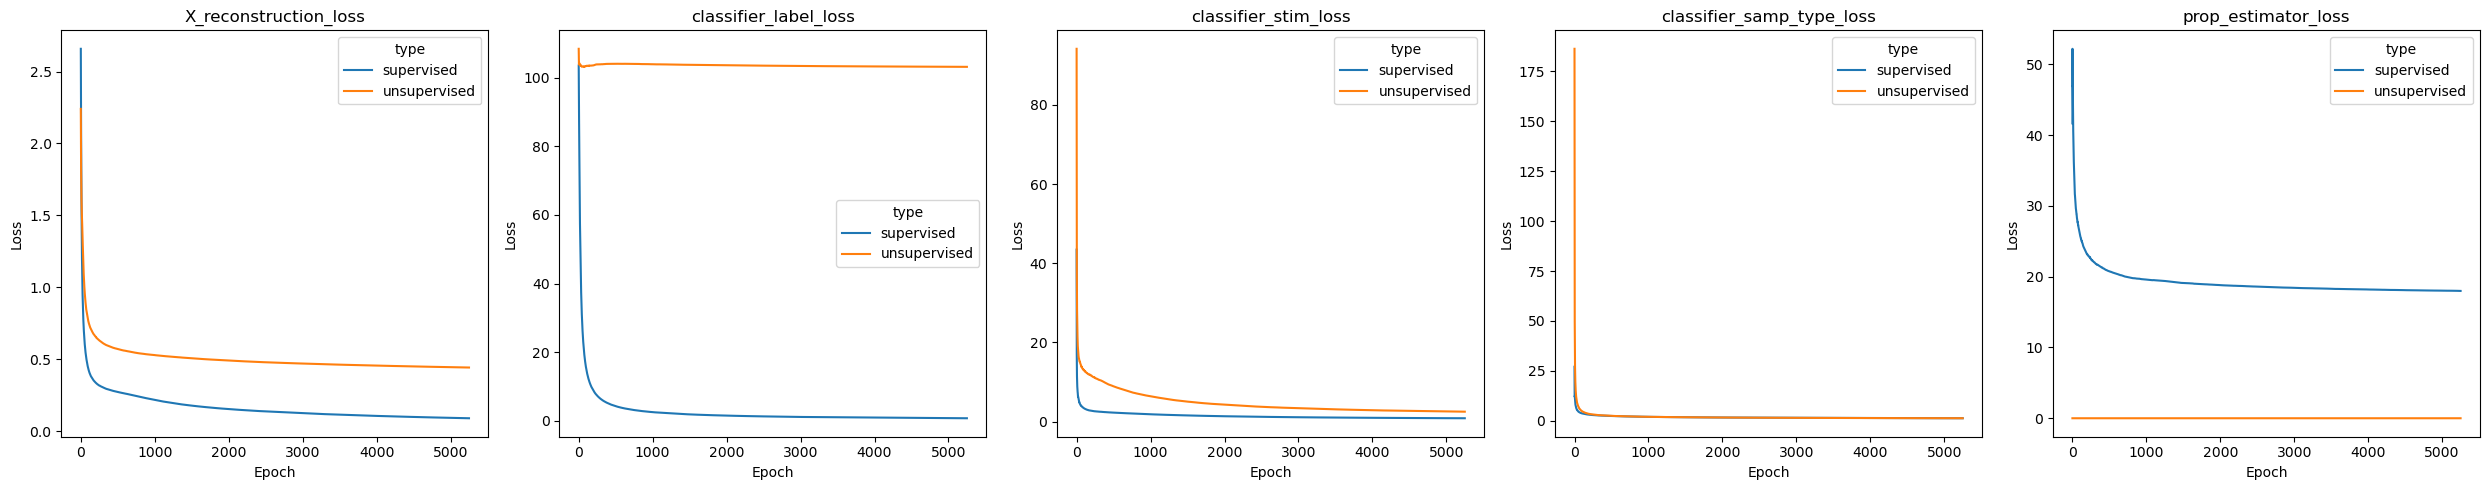

Training Model with config 17: 
RECONST_ALPHAS     10.0
CLS_ALPHAS        100.0
Y_ALPHAS          100.0
BETAS             100.0
LABEL_BETAS       100.0
SLACK_BETAS         0.1
Name: 17, dtype: float64
...



Epoch 10/10: 100%|██████████| 525/525 [03:07<00:00,  2.80it/s]
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['unsup_X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


Training complete!


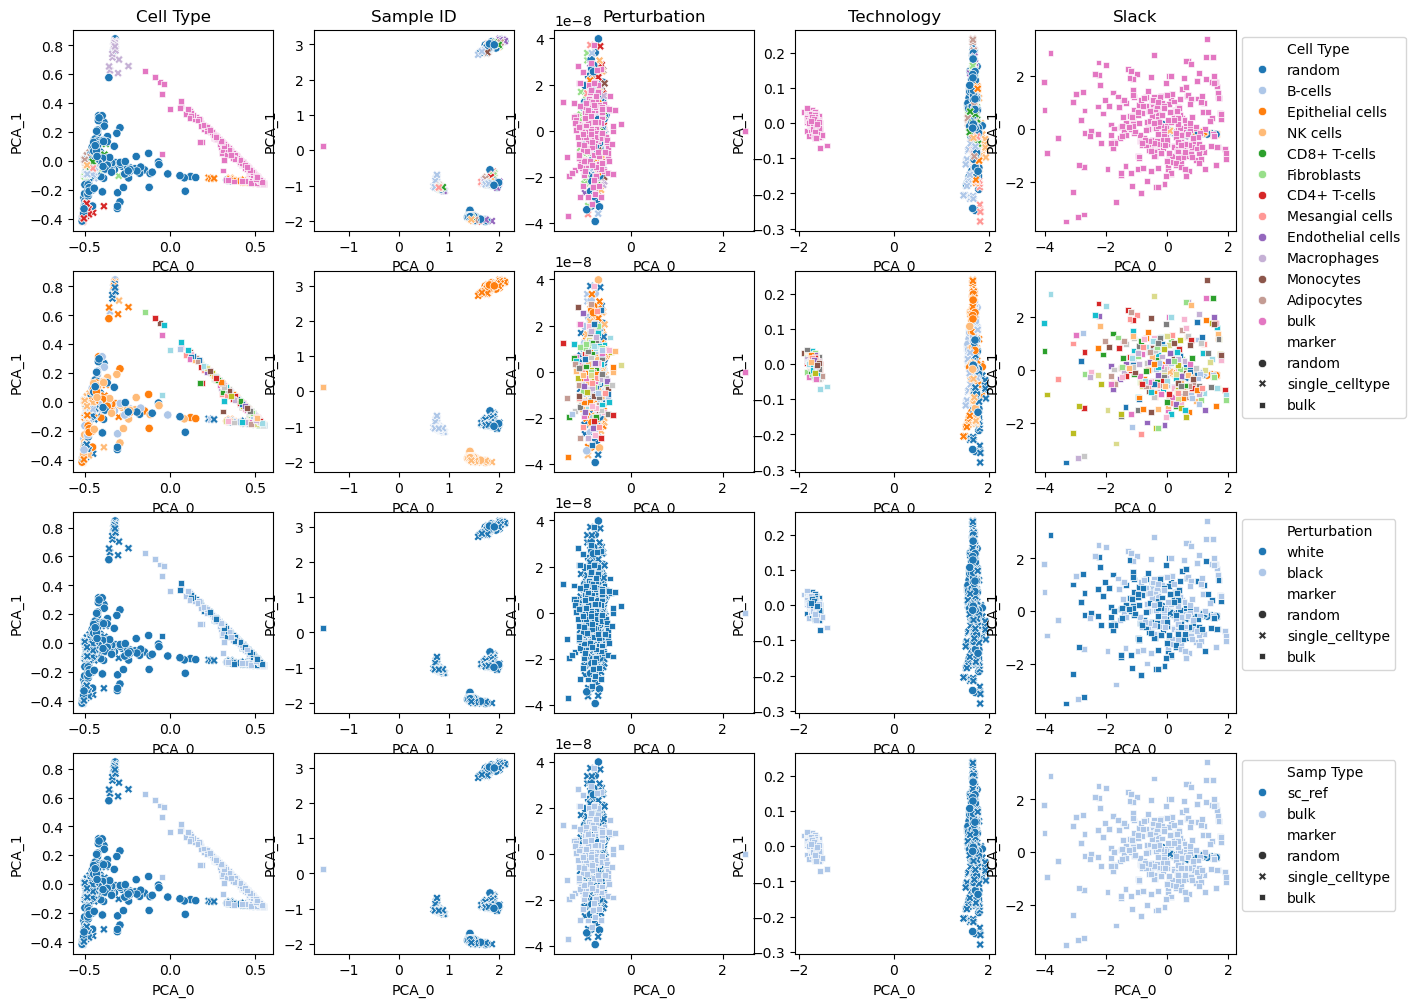

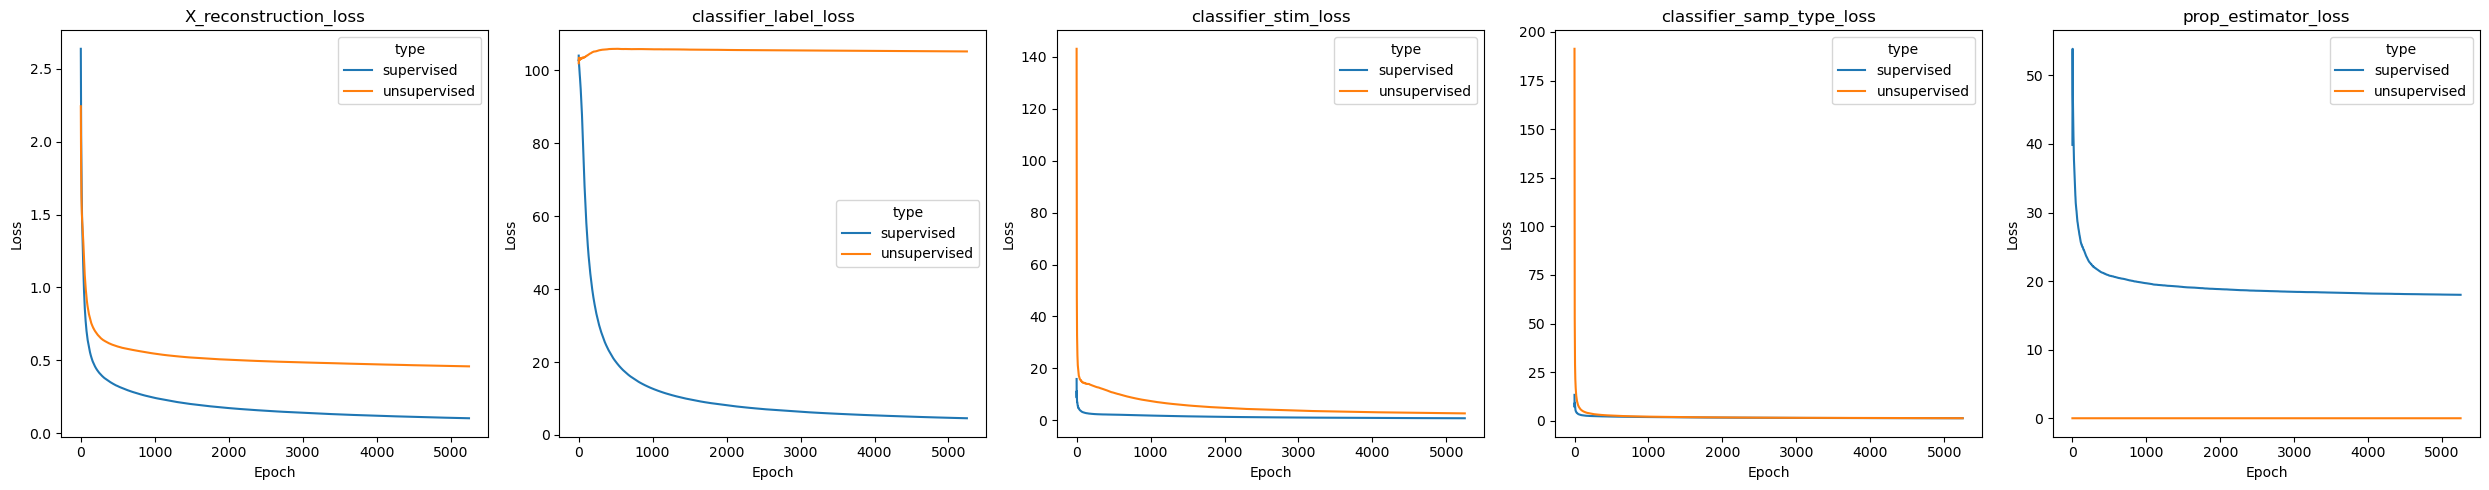

In [13]:
for i, row in hyperparam_grid.iterrows():

    tf.keras.backend.clear_session()

    model_id = uuid.uuid4().hex[:8]
    beta=float(row['BETAS'])
    label_beta=float(row['LABEL_BETAS'])
    slack_beta=float(row['SLACK_BETAS'])
    model_save_path = TRAINED_MODELS_PATH \
        / f"buddi4_{model_id};beta={beta};label_beta={label_beta};slack_beta={slack_beta}"

    obj = BuDDI4(
        n_x=n_x,
        n_y=n_y,
        n_labels=n_labels,
        n_stims=n_stims,
        n_samp_types=n_samp_types,
        z_dim=64,
        encoder_hidden_dim=512,
        decoder_hidden_dim=512,
        activation='relu',
        output_activation='sigmoid',
    )

    obj.set_reconstruction_loss(
        fn=MeanSquaredError(reduction='sum'),
        weight=float(row['RECONST_ALPHAS']),
    )
    obj.set_encoder_loss(
        branch='label',
        fn=kl_loss,
        weight=float(row['LABEL_BETAS']),    
    )
    obj.set_encoder_loss(
        branch='stim',
        fn=kl_loss,
        weight=float(row['BETAS']),    
    )
    obj.set_encoder_loss(
        branch='samp_type',
        fn=kl_loss,
        weight=float(row['BETAS']),    
    )
    obj.set_encoder_loss(
        branch='slack',
        fn=kl_loss,
        weight=float(row['SLACK_BETAS']),    
    )
    obj.set_predictor_loss(
        branch='label',
        fn=CategoricalCrossentropy(reduction='sum'),
        weight=float(row['CLS_ALPHAS']),
    )
    obj.set_predictor_loss(
        branch='stim',
        fn=CategoricalCrossentropy(reduction='sum'),
        weight=float(row['CLS_ALPHAS']),
    )
    obj.set_predictor_loss(
        branch='samp_type',
        fn=CategoricalCrossentropy(reduction='sum'),
        weight=float(row['CLS_ALPHAS']),
    )
    obj.set_prop_estimator_loss(
        fn=CategoricalCrossentropy(reduction='sum'),
        weight=float(row['Y_ALPHAS']),
    )

    obj.compile(optimizer=Adam(learning_rate=LEARNING_RATE))

    _loss_config = write_buddi4_loss_config(
        obj,
        None
    ).set_index('loss_name').to_dict(orient='index')
    if any([_loss_config == trained_cfg for trained_cfg in trained_configs]):
        print(f"Model with config {i}: \n{row}\n already trained, skipping...\n")
        continue
    else:
        print(f"Training Model with config {i}: \n{row}\n...\n")
    
    model_save_path.mkdir(parents=True, exist_ok=True)
    
    # write model loss config as yaml
    write_buddi4_loss_config(
        obj,
        model_save_path / f"loss_config.yaml",
    )

    # save the model architecture plots
    plot_model(
        obj.sup_model,
        to_file=model_save_path / f"model_sup.png",
        show_shapes=True
    )
    plot_model(
        obj.unsup_model,
        to_file=model_save_path / f"model_unsup.png",
        show_shapes=True
    )

    # fit the model
    all_loss_df = fit_buddi4(
        obj.sup_model, obj.unsup_model, 
        ds_sup, ds_unsup, 
        epochs=EPOCHS, batch_size=BATCH_SIZE, prefetch=True
    )

    # save model weights
    obj.save(
        model_save_path
    )

    # save latent space plots
    _ = plot_latent_spaces_buddi4(
        obj.unsup_model,
        X_tmp,
        meta_tmp,
        type='PCA',
        alpha=1,    
        panel_width=3,
        show_plot=True,
        save_path=model_save_path / 'latent_space.png',
        palette="tab20",
    )

    # save loss plot and csv
    all_loss_df['index'] = all_loss_df.index.to_list()
    plot_buddi4_loss(
        all_loss_df, 
        save_path=model_save_path / 'train_loss.png', 
        show_plot=True
    )

    all_loss_df.to_csv(
        model_save_path / 'train_loss.csv',
        index=False
    )

    del obj
    gc.collect()